Import Data from File

In [1]:
import numpy as np

from wfield import load_stack

dat = load_stack('/Users/ryan.gorzek/Documents/Trachtenberg Lab/Data/Ryan/ctb09/ctb09_spontaneous_dark/ctb09_spontaneous_dark_run000_00000000_1_512_512_uint16.dat')

F = np.percentile(dat.squeeze(),20,axis=0)
df = (dat.squeeze() - F)

Set Mask to Fit Cranial Window

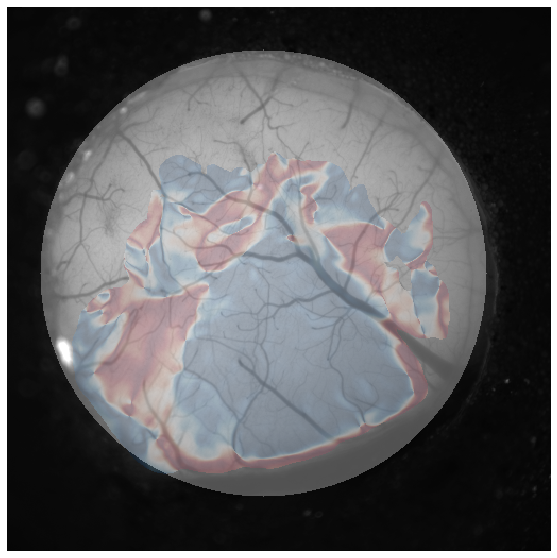

In [2]:
import matplotlib
matplotlib.use('Qt5Agg')

import matplotlib.pyplot as plt
import cv2

signmap = np.loadtxt('/Users/ryan.gorzek/Documents/Trachtenberg Lab/Data/Ryan/ctb09/ctb09_spontaneous_retinotopy/signmap.csv')

ref_frame = dat[1].squeeze().astype('float')

class Cursor:

    def __init__(self, ax):
        self.ax = ax
        self.horizontal_line = ax.axhline(color='k', lw=0.8, ls='--')
        self.vertical_line = ax.axvline(color='k', lw=0.8, ls='--')
        # text location in axes coordinates
        self.text = ax.text(0.72, 0.9, '', transform=ax.transAxes)

    def set_cross_hair_visible(self, visible):
        need_redraw = self.horizontal_line.get_visible() != visible
        self.horizontal_line.set_visible(visible)
        self.vertical_line.set_visible(visible)
        self.text.set_visible(visible)
        return need_redraw

    def on_mouse_move(self, event):
        if not event.inaxes:
            need_redraw = self.set_cross_hair_visible(False)
            if need_redraw:
                self.ax.figure.canvas.draw()
        else:
            self.set_cross_hair_visible(True)
            x, y = event.xdata, event.ydata
            # update the line positions
            self.horizontal_line.set_ydata(y)
            self.vertical_line.set_xdata(x)
            self.text.set_text('x=%1.2f, y=%1.2f' % (x, y))
            self.ax.figure.canvas.draw()

fig, ax = plt.subplots()

ax.imshow(dat[1].squeeze(),cmap = 'gray')
ax.axis('off')
ax.set_title('Select Center Point and Edge Point for Mask:',fontsize = 20,color = 'k')

fig.set_size_inches(10,10)

cursor = Cursor(ax)
fig.canvas.mpl_connect('motion_notify_event', cursor.on_mouse_move)

mask_coors = plt.ginput(n = 2,timeout = -1)

radius = np.linalg.norm(np.array(mask_coors[1]) - np.array(mask_coors[0]))

mask = np.zeros(dat[1].squeeze().shape,dtype = np.uint8)

circle = cv2.circle(mask,(int(mask_coors[0][0]),int(mask_coors[0][1])),int(radius),(255,255,255),-1)

%matplotlib inline

fig, ax = plt.subplots()

ax.imshow(dat[1].squeeze(),cmap = 'gray')
ax.imshow(signmap,cmap = 'RdBu_r',clim = [-1,1],alpha = 0.3)
ax.imshow(circle,cmap = 'gray',alpha = 0.3)
ax.axis('off')

fig.set_size_inches(10,10)

Mask Reference Frame and DF/F Matrix

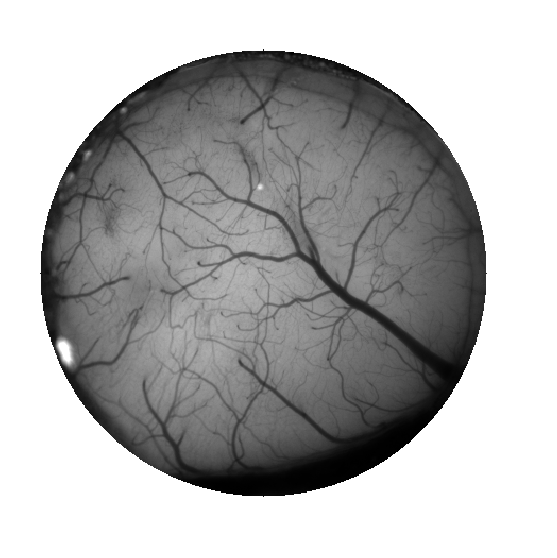

In [3]:
%matplotlib inline

np.add.at(ref_frame,(tuple(np.where(mask == 0)[0]),tuple(np.where(mask == 0)[1])),np.nan) # mask reference frame with nan

fig, ax = plt.subplots()

ax.imshow(ref_frame,cmap = 'gray')
ax.axis('off')

fig.set_size_inches(10,10)

# mask DF/F matrix

for frame in df:

    np.add.at(frame,(tuple(np.where(mask == 0)[0]),tuple(np.where(mask == 0)[1])),np.nan)

Select HVAs on Sign Map

In [4]:
import matplotlib
matplotlib.use('Qt5Agg')

import matplotlib.pyplot as plt

visual_areas = ('V1','LM','AL','RL','AM','PM')

area_bounds = dict.fromkeys(visual_areas)

for area in area_bounds:
    
    fig, ax = plt.subplots()

    ax.imshow(ref_frame,cmap = 'gray')
    ax.imshow(signmap,cmap = 'RdBu_r',clim = [-1,1],alpha = 0.3)
    ax.axis('off')
    ax.set_title('Select region for {ar} :'.format(ar = area),fontsize = 20, color = 'k')

    fig.set_size_inches(10,10)

    area_bounds[area] = plt.ginput(n = -1, timeout = -1)
    
    area_bounds[area].append(area_bounds[area][0]) # connect back to first point
    
plt.close('all')

Select Seeds

In [21]:
num_seeds = 20 # set number of seeds

import matplotlib
matplotlib.use('Qt5Agg')

fig, ax = plt.subplots()

ax.imshow(ref_frame,cmap = 'gray')
ax.imshow(signmap,cmap = 'RdBu_r',clim = [-1,1],alpha=0.3)
ax.axis('off')
ax.set_title('Select {ns} Seeds:'.format(ns = num_seeds),fontsize = 20, color = 'k')

fig.set_size_inches(10,10)

coors = plt.ginput(n = num_seeds, timeout = -1)

Calculate SCA Map

In [34]:
window_size = 2 # set pixel window size

corr_mat = np.zeros((num_seeds,df.shape[1],df.shape[2]))

round_coors = np.around(np.flip(coors,axis = 1),decimals=0).squeeze()

for seed in range(num_seeds):

    window_idx = np.arange(df.shape[1]).reshape(int(df.shape[1]/window_size),window_size)

    seed_idx = np.where(window_idx == round_coors[seed][0])[0],np.where(window_idx == round_coors[seed][1])[0]

    seed_mean = df[np.ix_(np.arange(df.shape[0]),window_idx[seed_idx[0],:].squeeze(),window_idx[seed_idx[1],:].squeeze())].mean(axis=(1,2))

    for row_idx in window_idx:
    
        for col_idx in window_idx:

            curr_mean = df[np.ix_(np.arange(df.shape[0]),row_idx,col_idx)].mean(axis=(1,2))
            
            if np.isnan(curr_mean).any():
                
                corr_mat[np.ix_(np.array([seed]),row_idx,col_idx)] = np.tile(np.nan,(window_size,window_size))
                
            else:
        
                PCC = np.corrcoef(seed_mean,curr_mean)

                corr_mat[np.ix_(np.array([seed]),row_idx,col_idx)] = np.tile(PCC[1,0],(window_size,window_size))

/Users/ryan.gorzek/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/ryan.gorzek/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


Plot Individual SCA Maps

KeyboardInterrupt: 

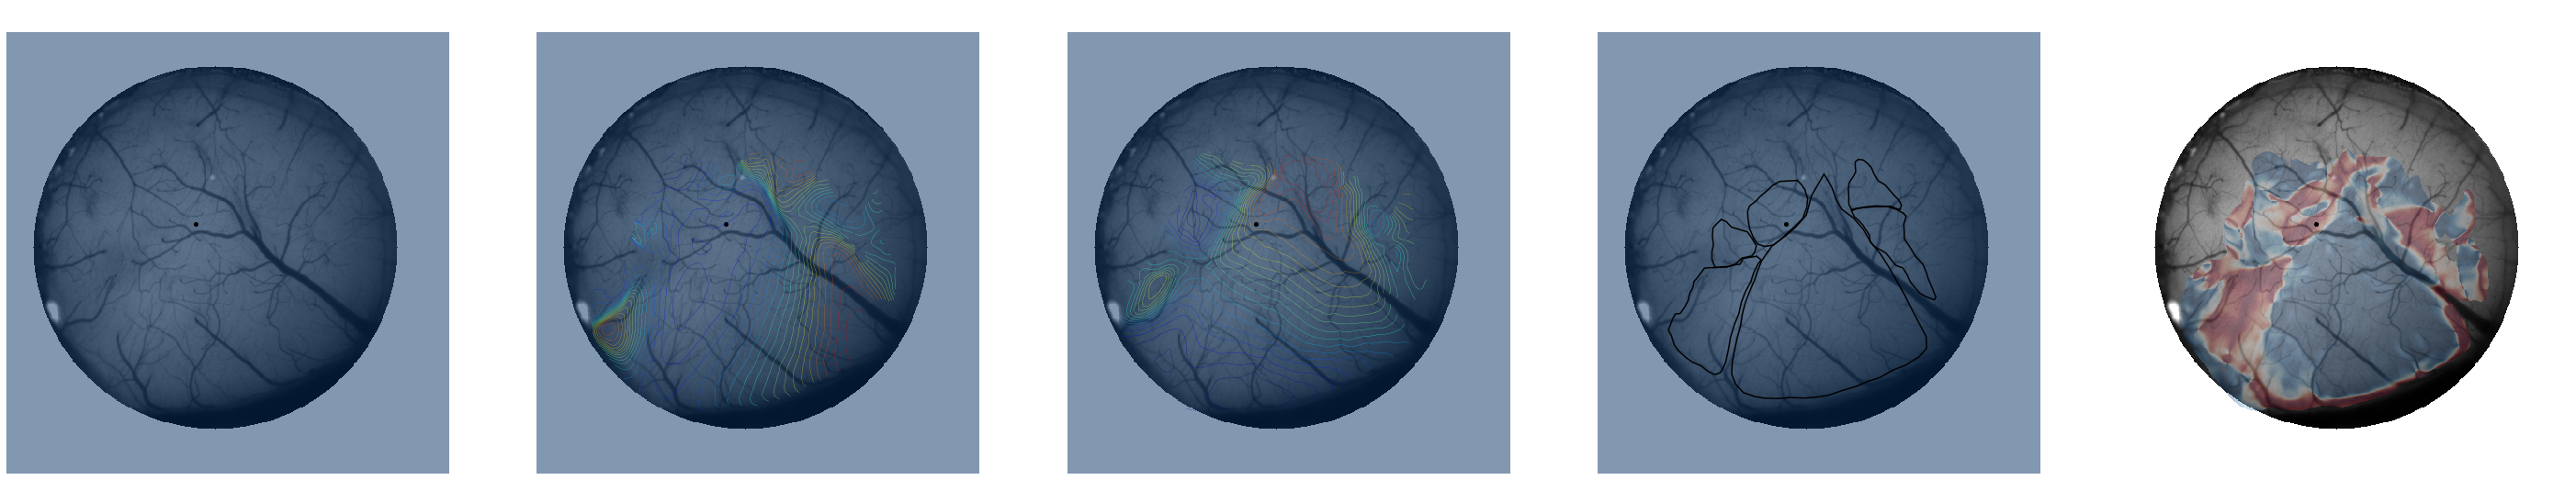

In [33]:
%matplotlib inline

fig_path = '/Users/ryan.gorzek/Documents/Trachtenberg Lab/Data/Ryan/ctb09/ctb09_spontaneous_dark/'

azimuth = np.loadtxt('/Users/ryan.gorzek/Documents/Trachtenberg Lab/Data/Ryan/ctb09/ctb09_spontaneous_retinotopy/azimuth.csv')
elevation = np.loadtxt('/Users/ryan.gorzek/Documents/Trachtenberg Lab/Data/Ryan/ctb09/ctb09_spontaneous_retinotopy/elevation.csv')

for seed in range(num_seeds):
    
    fig, axs = plt.subplots(1,5) # PCC map, azimuth + PCC map, elevation + PCC map, area bounds + PCC map, sign map
    
    # PCC map
    
    axs[0].imshow(ref_frame,cmap = 'gray')
    axs[0].imshow(corr_mat[seed],cmap = 'RdBu_r',clim = [0.8,1],alpha = 0.5)
    axs[0].scatter(coors[seed][0],coors[seed][1],color = 'k')
    axs[0].set_title('SCA Map',fontsize = 30,color = 'w')
    axs[0].axis('off')
    
    # PCC map + azimuth
    
    axs[1].imshow(ref_frame,cmap = 'gray')
    axs[1].imshow(corr_mat[seed],cmap = 'RdBu_r',clim = [0.8,1],alpha = 0.5)
    axs[1].scatter(coors[seed][0],coors[seed][1],color = 'k')
    axs[1].contour(azimuth,levels = np.arange(0,144,7.5),cmap = 'jet_r',alpha = 1,linewidths = 0.25)
    axs[1].set_title('Azimuth',fontsize = 30,color = 'w')
    axs[1].axis('off')
    
    # PCC map + elevation
    
    axs[2].imshow(ref_frame,cmap = 'gray')
    axs[2].imshow(corr_mat[seed],cmap = 'RdBu_r',clim = [0.8,1],alpha = 0.5)
    axs[2].scatter(coors[seed][0],coors[seed][1],color = 'k')
    axs[2].contour(elevation,levels = np.arange(0,100,5),cmap = 'jet_r',alpha = 1,linewidths = 0.25)
    axs[2].set_title('Elevation',fontsize = 30,color = 'w')
    axs[2].axis('off')
    
    # PCC map + area bounds
    
    axs[3].imshow(ref_frame,cmap = 'gray')
    axs[3].imshow(corr_mat[seed],cmap = 'RdBu_r',clim = [0.8,1],alpha = 0.5)
    axs[3].scatter(coors[seed][0],coors[seed][1],color = 'k')
    axs[3].set_title('Bounded Visual Areas',fontsize = 30,color = 'w')
    axs[3].axis('off')
    
    for area in area_bounds:
        
        bound_array = np.array(area_bounds[area])
        
        axs[3].plot(bound_array[:,0],bound_array[:,1],color = 'k')
    
    # sign map

    axs[4].imshow(ref_frame,cmap = 'gray')
    axs[4].imshow(signmap,cmap = 'RdBu_r',clim = [-1,1],alpha = 0.3)
    axs[4].scatter(coors[seed][0],coors[seed][1],color = 'k')
    axs[4].set_title('Sign Map',fontsize = 30,color = 'w')
    axs[4].axis('off')

    fig.set_size_inches(50,15)
    
    plt.savefig(fig_path+'seed_plot{sd}'.format(sd = seed))
    
    plt.close()

Plot Aggregate SCA Maps

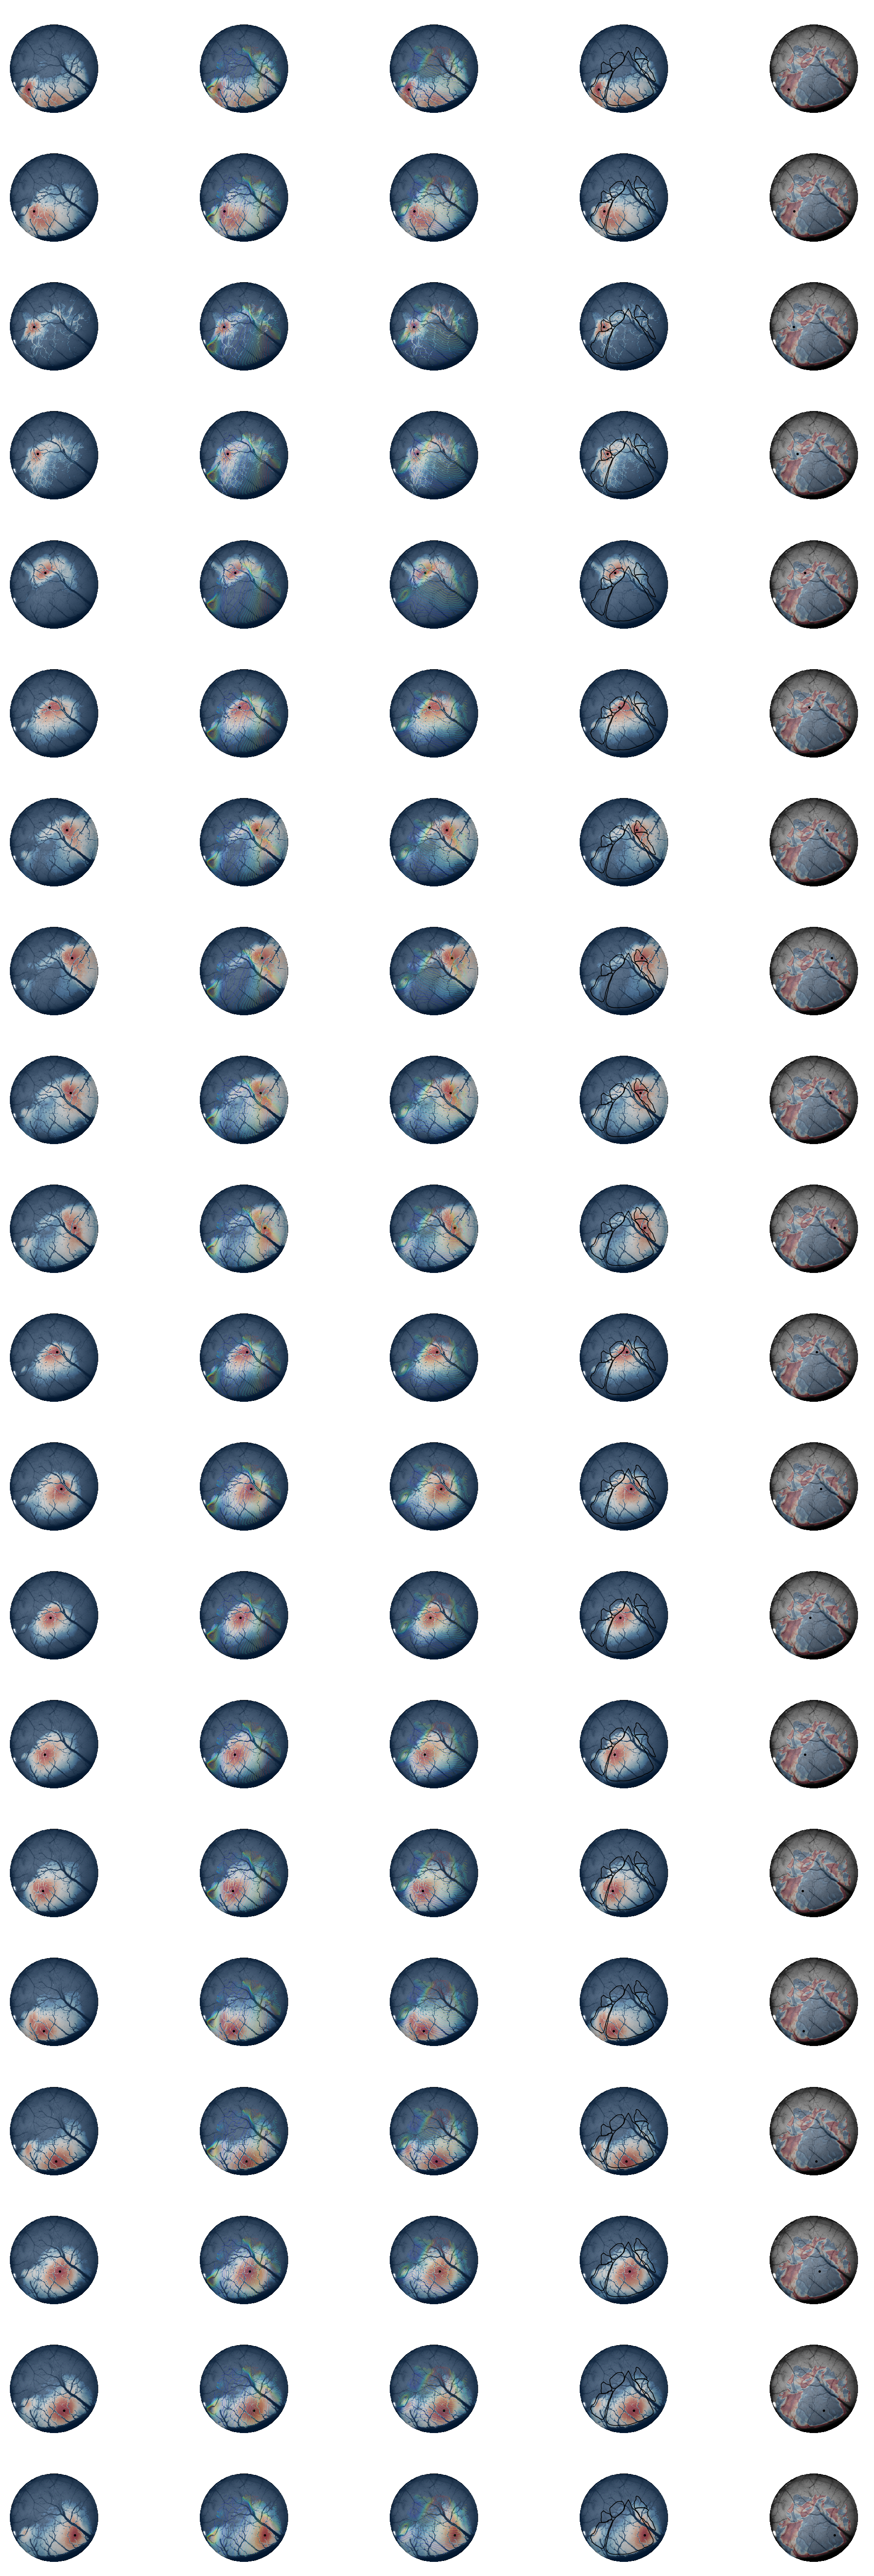

In [35]:
%matplotlib inline

fig_path = '/Users/ryan.gorzek/Documents/Trachtenberg Lab/Data/Ryan/ctb09/ctb09_spontaneous_dark/'

fig, axs = plt.subplots(num_seeds,5) # PCC map, azimuth + PCC map, elevation + PCC map, area bounds + PCC map, sign map

for seed in range(num_seeds):

    # PCC map
    
    axs[seed,0].imshow(ref_frame,cmap = 'gray')
    axs[seed,0].imshow(corr_mat[seed],cmap = 'RdBu_r',clim = [0.8,1],alpha = 0.5)
    axs[seed,0].scatter(coors[seed][0],coors[seed][1],color = 'k')
    if seed == 0: axs[seed,0].set_title('SCA Map',fontsize = 30,color = 'w')
    axs[seed,0].axis('off')
    
    # PCC map + azimuth
    
    axs[seed,1].imshow(ref_frame,cmap = 'gray')
    axs[seed,1].imshow(corr_mat[seed],cmap = 'RdBu_r',clim = [0.8,1],alpha = 0.5)
    axs[seed,1].scatter(coors[seed][0],coors[seed][1],color = 'k')
    axs[seed,1].contour(azimuth,levels = np.arange(0,144,7.5),cmap = 'jet_r',alpha = 1,linewidths = 0.25)
    if seed == 0: axs[seed,1].set_title('Azimuth',fontsize = 30,color = 'w')
    axs[seed,1].axis('off')
    
    # PCC map + elevation
    
    axs[seed,2].imshow(ref_frame,cmap = 'gray')
    axs[seed,2].imshow(corr_mat[seed],cmap = 'RdBu_r',clim = [0.8,1],alpha = 0.5)
    axs[seed,2].scatter(coors[seed][0],coors[seed][1],color = 'k')
    axs[seed,2].contour(elevation,levels = np.arange(0,100,5),cmap = 'jet_r',alpha = 1,linewidths = 0.25)
    if seed == 0: axs[seed,2].set_title('Elevation',fontsize = 30,color = 'w')
    axs[seed,2].axis('off')
    
    # PCC map + area bounds
    
    axs[seed,3].imshow(ref_frame,cmap = 'gray')
    axs[seed,3].imshow(corr_mat[seed],cmap = 'RdBu_r',clim = [0.8,1],alpha = 0.5)
    axs[seed,3].scatter(coors[seed][0],coors[seed][1],color = 'k')
    if seed == 0: axs[seed,3].set_title('Bounded Visual Areas',fontsize = 30,color = 'w')
    axs[seed,3].axis('off')
    
    for area in area_bounds:
        
        bound_array = np.array(area_bounds[area])
        
        axs[seed,3].plot(bound_array[:,0],bound_array[:,1],color = 'k')
    
    # sign map

    axs[seed,4].imshow(ref_frame,cmap = 'gray')
    axs[seed,4].imshow(signmap,cmap = 'RdBu_r',clim = [-1,1],alpha = 0.3)
    axs[seed,4].scatter(coors[seed][0],coors[seed][1],color = 'k')
    if seed == 0: axs[seed,4].set_title('Sign Map',fontsize = 30,color = 'w')
    axs[seed,4].axis('off')
    
fig.set_size_inches(35,100)

plt.savefig(fig_path+'SCA_plot_aggregate')

In [30]:
np.flip(coors,axis = 1)

array([[346.55174025, 119.34435029],
       [313.45678617, 145.82031356],
       [249.67378377, 145.21858712],
       [241.85134008, 162.66865381],
       [193.11149862, 198.77224008],
       [221.99436763, 218.02748609],
       [191.90804574, 302.26918738],
       [185.89078136, 325.73651845],
       [215.37537681, 318.5158012 ],
       [245.4616987 , 338.97450008],
       [221.39264119, 254.13107235],
       [260.50485965, 273.9880448 ],
       [260.50485965, 223.44302403],
       [297.81189879, 196.96706077],
       [332.71203218, 186.73771132],
       [386.26568514, 192.15324926],
       [394.08812883, 251.12244017],
       [304.4308896 , 267.36905398],
       [353.7724575 , 287.22602643],
       [331.5085793 , 339.57622652]])